In [1]:
from tensorflow.keras.datasets import imdb
from tensorflow import keras
from tensorflow.keras import layers, models, callbacks
import tensorflow as tf
import numpy as np

In [2]:
from sklearn.metrics import precision_score, recall_score, f1_score

In [3]:
(train_data, train_labels), (test_data, test_labels) = imdb.load_data(num_words=10000)

17464789/17464789 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [4]:
def vectorize_sequences(sequences, dimension=10000):
    results = np.zeros((len(sequences), dimension))
    for i, sequence in enumerate(sequences):
        results[i, sequence] = 1.
    return results
train_data = vectorize_sequences(train_data)
test_data = vectorize_sequences(test_data)

### 사용자 정의 지표 만들기 F1 Score

**Precision**
$$
\text{Precision} = \frac{\text{True Positives}}{\text{True Positives} + \text{False Positives}}
$$

**Recall**
$$
\text{Recall} = \frac{\text{True Positives}}{\text{True Positives} + \text{False Negatives}}
$$

**F1 Score**
$$
\text{F1 Score} = 2 \cdot \frac{\text{Precision} \cdot \text{Recall}}{\text{Precision} + \text{Recall}}
$$



In [5]:
from sklearn.model_selection import train_test_split

In [6]:
# 학습 데이터(train_data)에서 40%를 검증 데이터로 분리
train_data, val_data, train_labels, val_labels = train_test_split(train_data, train_labels, test_size=0.4, random_state=42)

In [7]:
# 데이터 분포 확인
unique, counts = np.unique(train_labels, return_counts=True)
print(dict(zip(unique, counts)))

{0: 7535, 1: 7465}


In [8]:
unique, counts = np.unique(val_labels, return_counts=True)
print(dict(zip(unique, counts)))

{0: 4965, 1: 5035}


In [9]:
unique, counts = np.unique(test_labels, return_counts=True)
print(dict(zip(unique, counts)))

{0: 12500, 1: 12500}


In [10]:
class MyMetric(tf.keras.metrics.Metric):
    def __init__(self, name="f1_score", **kwargs):
        """
        F1 Score를 계산하는 사용자 정의 Metric 클래스.
        - F1 Score는 Precision과 Recall의 조화 평균으로 정의 됨
        - Metric 클래스 초기화 시 True Positives, False Positives, False Negatives를 초기화

        Args:
        - name (str): Metric 이름 (기본값은 "f1_score").
        - **kwargs: 기타 Metric 관련 인자.
        """
        super().__init__(name=name, **kwargs)
        # True Positives, False Positives, False Negatives를 저장하는 상태 변수 생성
        self.true_positives = self.add_weight(name="tp", initializer="zeros")
        self.false_positives = self.add_weight(name="fp", initializer="zeros")
        self.false_negatives = self.add_weight(name="fn", initializer="zeros")

    def update_state(self, y_true, y_pred, sample_weight=None):
        """
        매 배치(batch)에서 True Positives, False Positives, False Negatives를 업데이트

        Args:
        - y_true: 실제 라벨 (0 또는 1).
        - y_pred: 모델의 예측값 (0 또는 1).
        - sample_weight: 각 샘플에 가중치를 줄 때 사용하는 선택적 인자.
        """
        # y_true와 y_pred를 float32로 변환
        threshold = 0.5  # 최적의 값으로 설정
        y_pred = tf.cast(y_pred > threshold, tf.float32)
        # y_pred = tf.cast(tf.round(y_pred), tf.float32)
        y_true = tf.cast(y_true, tf.float32)

        # True Positives: y_true와 y_pred가 모두 1인 경우
        self.true_positives.assign_add(tf.reduce_sum(y_true * y_pred))

        # False Positives: y_true가 0이고 y_pred가 1인 경우
        self.false_positives.assign_add(tf.reduce_sum((1 - y_true) * y_pred))

        # False Negatives: y_true가 1이고 y_pred가 0인 경우
        self.false_negatives.assign_add(tf.reduce_sum(y_true * (1 - y_pred)))

    def result(self):
        """
        F1 Score 계산:
        - Precision = True Positives / (True Positives + False Positives)
        - Recall = True Positives / (True Positives + False Negatives)
        - F1 Score = 2 * (Precision * Recall) / (Precision + Recall)

        Returns:
        - F1 Score 값.
        """
        # Precision 계산 (양성 예측 중 실제 양성의 비율)
        precision = self.true_positives / (self.true_positives + self.false_positives + 1e-7)

        # Recall 계산 (실제 양성 중 올바르게 예측된 비율)
        recall = self.true_positives / (self.true_positives + self.false_negatives + 1e-7)

        # F1 Score 계산 (Precision과 Recall의 조화 평균)
        return 2 * ((precision * recall) / (precision + recall + 1e-7))

    def reset_states(self):
        """
        Metric 상태를 초기화합니다. (에폭 시작 시 호출됨)
        - True Positives, False Positives, False Negatives 값을 0으로 초기화.
        """
        self.true_positives.assign(0)
        self.false_positives.assign(0)
        self.false_negatives.assign(0)

In [11]:
# Build the model
model = models.Sequential([
    layers.Input(shape=(10000,)),
    layers.Dense(16, activation="relu"),
    layers.Dense(16, activation="relu"),
    layers.Dense(1, activation="sigmoid")
])

# metrics 에 MyMetric() 에 추가
model.compile(optimizer="rmsprop",
              loss="binary_crossentropy",
              metrics=["accuracy", MyMetric()])

history = model.fit(train_data, train_labels,
                    epochs=5, batch_size=512,
                    validation_data=(val_data, val_labels))

Epoch 1/5
30/30 ━━━━━━━━━━━━━━━━━━━━ 5s 104ms/step - accuracy: 0.7052 - f1_score: 0.5312 - loss: 0.6007 - val_accuracy: 0.8654 - val_f1_score: 0.5099 - val_loss: 0.4068
Epoch 2/5
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 50ms/step - accuracy: 0.8953 - f1_score: 0.5033 - loss: 0.3494 - val_accuracy: 0.8821 - val_f1_score: 0.5024 - val_loss: 0.3200
Epoch 3/5
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 58ms/step - accuracy: 0.9192 - f1_score: 0.4962 - loss: 0.2496 - val_accuracy: 0.8819 - val_f1_score: 0.5222 - val_loss: 0.2948
Epoch 4/5
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 59ms/step - accuracy: 0.9349 - f1_score: 0.5007 - loss: 0.2040 - val_accuracy: 0.8846 - val_f1_score: 0.5074 - val_loss: 0.2828
Epoch 5/5
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 63ms/step - accuracy: 0.9495 - f1_score: 0.4978 - loss: 0.1635 - val_accuracy: 0.8763 - val_f1_score: 0.4843 - val_loss: 0.3006


- 위 결과를 보면 MyMetric에서 사용자 정의 지표로 구현한 f1_score 값이 0.5 근방에서 머물고 있는게 이상하다!
- 디버깅을 위해서 아래와 같이 callback 함수를 통해 Sklearn 과 Manual 로 f1_score 값을 구할 수 있는 class 를 만들어 추가 한다.
- 원래 각각 구현한 2개의 class 를 동일한 시점에 계산 할 수 있도록 하나의 함수로 merge 하였다

In [12]:
# # Define custom callback for metrics
# class sklearn_MetricsCallback(callbacks.Callback):
#     def __init__(self, val_data):
#         super().__init__()
#         self.val_data = val_data

#     def on_epoch_end(self, epoch, logs=None):
#         y_pred = (self.model.predict(self.val_data[0]) > 0.5).astype(int)
#         y_true = self.val_data[1]
#         precision = precision_score(y_true, y_pred)
#         recall = recall_score(y_true, y_pred)
#         f1 = f1_score(y_true, y_pred)
#         print(f"Epoch {epoch + 1} - sklearn Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1:.4f}")


In [13]:
# # Define custom callback for metrics
# class MetricsCallback(callbacks.Callback):
#     def __init__(self, val_data):
#         super().__init__()
#         self.val_data = val_data

#     def on_epoch_end(self, epoch, logs=None):
#        y_pred = (self.model.predict(self.val_data[0]) > 0.5).astype(int)
#        y_true = self.val_data[1]

#         # Manual metrics calculation using TensorFlow for consistency
#         true_positives = tf.reduce_sum(tf.cast(y_true_tf * y_pred, tf.float32))
#         false_positives = tf.reduce_sum(tf.cast((1 - y_true_tf) * y_pred, tf.float32))
#         false_negatives = tf.reduce_sum(tf.cast(y_true_tf * (1 - y_pred), tf.float32))

#         precision_manual = true_positives / (true_positives + false_positives + 1e-7)
#         recall_manual = true_positives / (true_positives + false_negatives + 1e-7)
#         f1_manual = 2 * (precision_manual * recall_manual) / (precision_manual + recall_manual + 1e-7)

#         print(f"Epoch {epoch + 1} - Manually Precision: {precision_manual.numpy():.4f}, Recall: {recall_manual.numpy():.4f}, F1 Score: {f1_manual.numpy():.4f}")

In [14]:
# Define unified callback for both sklearn and manual metric calculations
class CombinedMetricsCallback(callbacks.Callback):
    def __init__(self, val_data):
        super().__init__()
        self.val_data = val_data

    def on_epoch_end(self, epoch, logs=None):
        y_pred = (self.model.predict(self.val_data[0]) > 0.5).astype(int)
        y_true = self.val_data[1]

        # Sklearn metrics
        precision_sklearn = precision_score(y_true, y_pred)
        recall_sklearn = recall_score(y_true, y_pred)
        f1_sklearn = f1_score(y_true, y_pred)
        print(f"Epoch {epoch + 1} - sklearn Precision: {precision_sklearn:.4f}, Recall: {recall_sklearn:.4f}, F1 Score: {f1_sklearn:.4f}")

        # Manual metrics calculation using TensorFlow for consistency
        true_positives = tf.reduce_sum(tf.cast(y_true * y_pred, tf.float32))
        false_positives = tf.reduce_sum(tf.cast((1 - y_true) * y_pred, tf.float32))
        false_negatives = tf.reduce_sum(tf.cast(y_true * (1 - y_pred), tf.float32))

        precision_manual = true_positives / (true_positives + false_positives + 1e-7)
        recall_manual = true_positives / (true_positives + false_negatives + 1e-7)
        f1_manual = 2 * (precision_manual * recall_manual) / (precision_manual + recall_manual + 1e-7)

        print(f"Epoch {epoch + 1} - Manually Precision: {precision_manual.numpy():.4f}, Recall: {recall_manual.numpy():.4f}, F1 Score: {f1_manual.numpy():.4f}")

In [15]:
# Build the model
model = models.Sequential([
    layers.Input(shape=(10000,)),
    layers.Dense(16, activation="relu"),
    layers.Dense(16, activation="relu"),
    layers.Dense(1, activation="sigmoid")
])

# metrics 에 MyMetric() 에 추가
model.compile(optimizer="rmsprop",
              loss="binary_crossentropy",
              metrics=["accuracy", MyMetric()])

# Train the model with both custom callbacks
# sklearn_metrics_callback = sklearn_MetricsCallback((val_data, val_labels))
# manual_metrics_callback = MetricsCallback((val_data, val_labels))
# history = model.fit(train_data, train_labels,
#                     epochs=5, batch_size=512,
#                     validation_data=(val_data, val_labels),
#                     callbacks=[sklearn_metrics_callback, manual_metrics_callback])

# Train the model with the combined callback
combined_metrics_callback = CombinedMetricsCallback((val_data, val_labels))
history = model.fit(train_data, train_labels,
                    epochs=5, batch_size=512,
                    validation_data=(val_data, val_labels),
                    callbacks=[combined_metrics_callback])

Epoch 1/5
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Epoch 1 - sklearn Precision: 0.8853, Recall: 0.8354, F1 Score: 0.8596
Epoch 1 - Manually Precision: 0.5035, Recall: 0.4751, F1 Score: 0.4889
30/30 ━━━━━━━━━━━━━━━━━━━━ 11s 329ms/step - accuracy: 0.6900 - f1_score: 0.5404 - loss: 0.5896 - val_accuracy: 0.8626 - val_f1_score: 0.4897 - val_loss: 0.3841
Epoch 2/5
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Epoch 2 - sklearn Precision: 0.8208, Recall: 0.9452, F1 Score: 0.8786
Epoch 2 - Manually Precision: 0.5035, Recall: 0.5798, F1 Score: 0.5390
30/30 ━━━━━━━━━━━━━━━━━━━━ 8s 266ms/step - accuracy: 0.8956 - f1_score: 0.5000 - loss: 0.3268 - val_accuracy: 0.8685 - val_f1_score: 0.5397 - val_loss: 0.3306
Epoch 3/5
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Epoch 3 - sklearn Precision: 0.8687, Recall: 0.9067, F1 Score: 0.8873
Epoch 3 - Manually Precision: 0.5035, Recall: 0.5255, F1 Score: 0.5143
30/30 ━━━━━━━━━━━━━━━━━━━━ 7s 237ms/step - accuracy: 0.9243 - f1_score: 0.5041 - loss: 0.2383 - val_accur

- 위 값을 비교해 보니 역시나 epoch 마다 sklearn 과 Manual F1 Score 값이 너무 차이가 많이 난다!!
- Manual 함수에서 TP, FP, FN 을 직접 구하지 않고 confusion_matrix 를 이용해서  F1 Score 를 구하도록 수정 하고 디버깅 한다.
- 디버깅을 위해 TP, FP, FN 을 출력한다.

In [16]:
from sklearn.metrics import confusion_matrix

In [17]:
# Define unified callback for both sklearn and manual metric calculations
class CombinedMetricsCallback(callbacks.Callback):
    def __init__(self, val_data):
        super().__init__()
        self.val_data = val_data

    def on_epoch_end(self, epoch, logs=None):
        y_pred = (self.model.predict(self.val_data[0]) > 0.5).astype(int)
        y_true = self.val_data[1]

        # Sklearn metrics
        precision_sklearn = precision_score(y_true, y_pred)
        recall_sklearn = recall_score(y_true, y_pred)
        f1_sklearn = f1_score(y_true, y_pred)
        print(f"Epoch {epoch + 1} - sklearn Precision: {precision_sklearn:.4f}, Recall: {recall_sklearn:.4f}, F1 Score: {f1_sklearn:.4f}")

        # Manual metrics calculation using confusion_matrix
        tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
        # Logging true positive, false positive, and false negative counts
        print(f"Epoch {epoch + 1} - True Positives: {tp}, False Positives: {fp}, False Negatives: {fn}")

        precision_manual = tp / (tp + fp + 1e-7)
        recall_manual = tp / (tp + fn + 1e-7)
        f1_manual = 2 * (precision_manual * recall_manual) / (precision_manual + recall_manual + 1e-7)

        print(f"Epoch {epoch + 1} - Manually Precision: {precision_manual:.4f}, Recall: {recall_manual:.4f}, F1 Score: {f1_manual:.4f}")

In [18]:
# Build the model
model = models.Sequential([
    layers.Input(shape=(10000,)),
    layers.Dense(16, activation="relu"),
    layers.Dense(16, activation="relu"),
    layers.Dense(1, activation="sigmoid")
])

# metrics 에 MyMetric() 에 추가
model.compile(optimizer="rmsprop",
              loss="binary_crossentropy",
              metrics=["accuracy", MyMetric()])

# Train the model with the combined callback
combined_metrics_callback = CombinedMetricsCallback((val_data, val_labels))
history = model.fit(train_data, train_labels,
                    epochs=5, batch_size=512,
                    validation_data=(val_data, val_labels),
                    callbacks=[combined_metrics_callback])

Epoch 1/5
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Epoch 1 - sklearn Precision: 0.8262, Recall: 0.9142, F1 Score: 0.8680
Epoch 1 - True Positives: 4603, False Positives: 968, False Negatives: 432
Epoch 1 - Manually Precision: 0.8262, Recall: 0.9142, F1 Score: 0.8680
30/30 ━━━━━━━━━━━━━━━━━━━━ 4s 109ms/step - accuracy: 0.6702 - f1_score: 0.3519 - loss: 0.6130 - val_accuracy: 0.8600 - val_f1_score: 0.5300 - val_loss: 0.4207
Epoch 2/5
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Epoch 2 - sklearn Precision: 0.8918, Recall: 0.8645, F1 Score: 0.8780
Epoch 2 - True Positives: 4353, False Positives: 528, False Negatives: 682
Epoch 2 - Manually Precision: 0.8918, Recall: 0.8645, F1 Score: 0.8780
30/30 ━━━━━━━━━━━━━━━━━━━━ 4s 119ms/step - accuracy: 0.8917 - f1_score: 0.4957 - loss: 0.3572 - val_accuracy: 0.8790 - val_f1_score: 0.4965 - val_loss: 0.3277
Epoch 3/5
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Epoch 3 - sklearn Precision: 0.9241, Recall: 0.8129, F1 Score: 0.8650
Epoch 3 - True Positives: 4

- 역시 예상대로 confusion_matrix 로 계산한 결과는 동일 하게 나왔다!
- F1 Score 계산식에는 문제가 없다는 소리이고 precision 과 recall 값이 이상하게 나온다는 소리다!
- y_pred 와 y_true 의 shape 을 확인한다.
- 디버깅을 위해 TP, FP, FN 을 출력 할 수 있게 수정 한다.

In [19]:
# Define unified callback for both sklearn and manual metric calculations
class CombinedMetricsCallback(callbacks.Callback):
    def __init__(self, val_data):
        super().__init__()
        self.val_data = val_data

    def on_epoch_end(self, epoch, logs=None):
        y_pred = (self.model.predict(self.val_data[0]) > 0.5).astype(int)
        y_true = self.val_data[1]
        print(f"y_true shape: {y_true.shape}, y_pred shape: {y_pred.shape}")
        # Sklearn metrics
        precision_sklearn = precision_score(y_true, y_pred)
        recall_sklearn = recall_score(y_true, y_pred)
        f1_sklearn = f1_score(y_true, y_pred)
        print(f"Epoch {epoch + 1} - sklearn Precision: {precision_sklearn:.4f}, Recall: {recall_sklearn:.4f}, F1 Score: {f1_sklearn:.4f}")

        # Manual metrics calculation using TensorFlow for consistency
        true_positives = tf.reduce_sum(tf.cast(y_true * y_pred, tf.float32))
        false_positives = tf.reduce_sum(tf.cast((1 - y_true) * y_pred, tf.float32))
        false_negatives = tf.reduce_sum(tf.cast(y_true * (1 - y_pred), tf.float32))

        # Logging true positive, false positive, and false negative counts
        print(f"Epoch {epoch + 1} - True Positives: {true_positives.numpy()}, False Positives: {false_positives.numpy()}, False Negatives: {false_negatives.numpy()}")

        precision_manual = true_positives / (true_positives + false_positives + 1e-7)
        recall_manual = true_positives / (true_positives + false_negatives + 1e-7)
        f1_manual = 2 * (precision_manual * recall_manual) / (precision_manual + recall_manual + 1e-7)

        print(f"Epoch {epoch + 1} - Manually Precision: {precision_manual.numpy():.4f}, Recall: {recall_manual.numpy():.4f}, F1 Score: {f1_manual.numpy():.4f}")

In [20]:
# Build the model
model = models.Sequential([
    layers.Input(shape=(10000,)),
    layers.Dense(16, activation="relu"),
    layers.Dense(16, activation="relu"),
    layers.Dense(1, activation="sigmoid")
])

# Compile the model with custom metric
model.compile(optimizer="rmsprop",
              loss="binary_crossentropy",
              metrics=["accuracy", MyMetric()])

# Train the model with the combined callback
combined_metrics_callback = CombinedMetricsCallback((val_data, val_labels))
history = model.fit(train_data, train_labels,
                    epochs=5, batch_size=512,
                    validation_data=(val_data, val_labels),
                    callbacks=[combined_metrics_callback])

Epoch 1/5
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
y_true shape: (10000,), y_pred shape: (10000, 1)
Epoch 1 - sklearn Precision: 0.8887, Recall: 0.8278, F1 Score: 0.8572
Epoch 1 - True Positives: 23614150.0, False Positives: 23285850.0, False Negatives: 26735850.0
Epoch 1 - Manually Precision: 0.5035, Recall: 0.4690, F1 Score: 0.4856
30/30 ━━━━━━━━━━━━━━━━━━━━ 14s 449ms/step - accuracy: 0.6958 - f1_score: 0.4363 - loss: 0.5977 - val_accuracy: 0.8611 - val_f1_score: 0.4865 - val_loss: 0.3988
Epoch 2/5
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
y_true shape: (10000,), y_pred shape: (10000, 1)
Epoch 2 - sklearn Precision: 0.8616, Recall: 0.9090, F1 Score: 0.8847
Epoch 2 - True Positives: 26745920.0, False Positives: 26374080.0, False Negatives: 23604080.0
Epoch 2 - Manually Precision: 0.5035, Recall: 0.5312, F1 Score: 0.5170
30/30 ━━━━━━━━━━━━━━━━━━━━ 20s 426ms/step - accuracy: 0.8946 - f1_score: 0.4976 - loss: 0.3395 - val_accuracy: 0.8807 - val_f1_score: 0.5179 - val_loss: 0.3155
Epoch 3/

- 역시 TP, FP, FN 값 자체가 이상하다!
- shape 을 찍어보면 y_true shape: (10000,), y_pred shape: (10000, 1) 으로 shape 이 다르다!
- y_pred 를 reshape 로 shape 을 맞춰준다.

In [21]:
# Define unified callback for both sklearn and manual metric calculations
class CombinedMetricsCallback(callbacks.Callback):
    def __init__(self, val_data):
        super().__init__()
        self.val_data = val_data

    def on_epoch_end(self, epoch, logs=None):
        y_pred = (self.model.predict(self.val_data[0]) > 0.5).astype(int)
        y_pred = y_pred.reshape(-1)  # Flatten y_pred to match y_true's shape
        y_true = self.val_data[1]
        print(f"y_true shape: {y_true.shape}, y_pred shape: {y_pred.shape}")
        # Sklearn metrics
        precision_sklearn = precision_score(y_true, y_pred)
        recall_sklearn = recall_score(y_true, y_pred)
        f1_sklearn = f1_score(y_true, y_pred)
        print(f"Epoch {epoch + 1} - sklearn Precision: {precision_sklearn:.4f}, Recall: {recall_sklearn:.4f}, F1 Score: {f1_sklearn:.4f}")

        # Manual metrics calculation using TensorFlow for consistency
        true_positives = tf.reduce_sum(tf.cast(y_true * y_pred, tf.float32))
        false_positives = tf.reduce_sum(tf.cast((1 - y_true) * y_pred, tf.float32))
        false_negatives = tf.reduce_sum(tf.cast(y_true * (1 - y_pred), tf.float32))

        # Logging true positive, false positive, and false negative counts
        print(f"Epoch {epoch + 1} - True Positives: {true_positives.numpy()}, False Positives: {false_positives.numpy()}, False Negatives: {false_negatives.numpy()}")

        precision_manual = true_positives / (true_positives + false_positives + 1e-7)
        recall_manual = true_positives / (true_positives + false_negatives + 1e-7)
        f1_manual = 2 * (precision_manual * recall_manual) / (precision_manual + recall_manual + 1e-7)

        print(f"Epoch {epoch + 1} - Manually Precision: {precision_manual.numpy():.4f}, Recall: {recall_manual.numpy():.4f}, F1 Score: {f1_manual.numpy():.4f}")

In [22]:
# Build the model
model = models.Sequential([
    layers.Input(shape=(10000,)),
    layers.Dense(16, activation="relu"),
    layers.Dense(16, activation="relu"),
    layers.Dense(1, activation="sigmoid")
])

# Compile the model with custom metric
model.compile(optimizer="rmsprop",
              loss="binary_crossentropy",
              metrics=["accuracy", MyMetric()])

# Train the model with the combined callback
combined_metrics_callback = CombinedMetricsCallback((val_data, val_labels))
history = model.fit(train_data, train_labels,
                    epochs=5, batch_size=512,
                    validation_data=(val_data, val_labels),
                    callbacks=[combined_metrics_callback])

Epoch 1/5
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
y_true shape: (10000,), y_pred shape: (10000,)
Epoch 1 - sklearn Precision: 0.8351, Recall: 0.8941, F1 Score: 0.8636
Epoch 1 - True Positives: 4502.0, False Positives: 889.0, False Negatives: 533.0
Epoch 1 - Manually Precision: 0.8351, Recall: 0.8941, F1 Score: 0.8636
30/30 ━━━━━━━━━━━━━━━━━━━━ 6s 149ms/step - accuracy: 0.6936 - f1_score: 0.3915 - loss: 0.6145 - val_accuracy: 0.8578 - val_f1_score: 0.5217 - val_loss: 0.4283
Epoch 2/5
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
y_true shape: (10000,), y_pred shape: (10000,)
Epoch 2 - sklearn Precision: 0.8516, Recall: 0.9140, F1 Score: 0.8817
Epoch 2 - True Positives: 4602.0, False Positives: 802.0, False Negatives: 433.0
Epoch 2 - Manually Precision: 0.8516, Recall: 0.9140, F1 Score: 0.8817
30/30 ━━━━━━━━━━━━━━━━━━━━ 4s 123ms/step - accuracy: 0.8853 - f1_score: 0.4973 - loss: 0.3705 - val_accuracy: 0.8765 - val_f1_score: 0.5224 - val_loss: 0.3325
Epoch 3/5
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 

- shape 을 맞추니 드디어 동일한 계산값이 나왔다!!
- Sklearn F1 Score 는 자체적으로 confusion_matrix 계산전에 shape 을 맞추어서 계산 하도록 구현 되어 있는 걸로 추정 된다.
- manual_confusion_matrix 로 함수를 만들어 재사용 가능 하도록 수정 하였다.
- y_true와 y_pred를 F1 Score 계산을 위해 모두 tf.float32로 변환하고, 차원을 맞추기 위해 tf.reshape()를 사용한다.

In [23]:
# Function to calculate confusion matrix manually
def manual_confusion_matrix(y_true, y_pred):
    # Ensure y_true and y_pred are integers and of the same shape
    y_true = tf.cast(tf.reshape(y_true, [-1]), tf.float32)
    y_pred = tf.cast(tf.reshape(y_pred, [-1]), tf.float32)

    true_positives = tf.reduce_sum(y_true * y_pred)
    false_positives = tf.reduce_sum((1 - y_true) * y_pred)
    true_negatives = tf.reduce_sum((1 - y_true) * (1 - y_pred))
    false_negatives = tf.reduce_sum(y_true * (1 - y_pred))
    return true_negatives, false_positives, false_negatives, true_positives

In [24]:
# Define unified callback for both sklearn and manual metric calculations
class CombinedMetricsCallback(callbacks.Callback):
    def __init__(self, val_data):
        super().__init__()
        self.val_data = val_data

    def on_epoch_end(self, epoch, logs=None):
        y_pred = (self.model.predict(self.val_data[0]) > 0.5).astype(int)
        y_true = self.val_data[1]

        # Sklearn metrics
        precision_sklearn = precision_score(y_true, y_pred)
        recall_sklearn = recall_score(y_true, y_pred)
        f1_sklearn = f1_score(y_true, y_pred)
        print(f"Epoch {epoch + 1} - sklearn Precision: {precision_sklearn:.4f}, Recall: {recall_sklearn:.4f}, F1 Score: {f1_sklearn:.4f}")

        # Manual metrics calculation using manual_confusion_matrix
        tn, fp, fn, tp = manual_confusion_matrix(y_true, y_pred)

        # Logging true positive, false positive, and false negative counts
        print(f"Epoch {epoch + 1} - True Positives: {tp.numpy()}, False Positives: {fp.numpy()}, False Negatives: {fn.numpy()}")

        precision_manual = tp / (tp + fp + 1e-7)
        recall_manual = tp / (tp + fn + 1e-7)
        f1_manual = 2 * (precision_manual * recall_manual) / (precision_manual + recall_manual + 1e-7)

        print(f"Epoch {epoch + 1} - Manually Precision: {precision_manual.numpy():.4f}, Recall: {recall_manual.numpy():.4f}, F1 Score: {f1_manual.numpy():.4f}")


In [25]:
# Build the model
model = models.Sequential([
    layers.Input(shape=(10000,)),
    layers.Dense(16, activation="relu"),
    layers.Dense(16, activation="relu"),
    layers.Dense(1, activation="sigmoid")
])

# Compile the model with custom metric
model.compile(optimizer="rmsprop",
              loss="binary_crossentropy",
              metrics=["accuracy", MyMetric()])

# Train the model with the combined callback
combined_metrics_callback = CombinedMetricsCallback((val_data, val_labels))
history = model.fit(train_data, train_labels,
                    epochs=5, batch_size=512,
                    validation_data=(val_data, val_labels),
                    callbacks=[combined_metrics_callback])

Epoch 1/5
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Epoch 1 - sklearn Precision: 0.8137, Recall: 0.9239, F1 Score: 0.8653
Epoch 1 - True Positives: 4652.0, False Positives: 1065.0, False Negatives: 383.0
Epoch 1 - Manually Precision: 0.8137, Recall: 0.9239, F1 Score: 0.8653
30/30 ━━━━━━━━━━━━━━━━━━━━ 4s 109ms/step - accuracy: 0.6948 - f1_score: 0.5727 - loss: 0.6004 - val_accuracy: 0.8552 - val_f1_score: 0.5363 - val_loss: 0.4058
Epoch 2/5
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Epoch 2 - sklearn Precision: 0.8135, Recall: 0.9496, F1 Score: 0.8763
Epoch 2 - True Positives: 4781.0, False Positives: 1096.0, False Negatives: 254.0
Epoch 2 - Manually Precision: 0.8135, Recall: 0.9496, F1 Score: 0.8763
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 79ms/step - accuracy: 0.8906 - f1_score: 0.4940 - loss: 0.3421 - val_accuracy: 0.8650 - val_f1_score: 0.5433 - val_loss: 0.3373
Epoch 3/5
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Epoch 3 - sklearn Precision: 0.8329, Recall: 0.9422, F1 Score: 0.8842
Epoch 3 - True

- CombinedMetricsCallback 는 정상적으로 수정이 되었다.
- 마지막으로 사용자 정의 지표로 만든 MyMetric 을 수정 한다.

In [31]:
class MyMetric(tf.keras.metrics.Metric):
    def __init__(self, name="f1_score", **kwargs):
        """
        F1 Score를 계산하는 사용자 정의 Metric 클래스.
        - F1 Score는 Precision과 Recall의 조화 평균으로 정의 됨
        - Metric 클래스 초기화 시 True Positives, False Positives, False Negatives를 초기화

        Args:
        - name (str): Metric 이름 (기본값은 "f1_score").
        - **kwargs: 기타 Metric 관련 인자.
        """
        super().__init__(name=name, **kwargs)
        # True Positives, False Positives, False Negatives를 저장하는 상태 변수 생성
        self.true_positives = self.add_weight(name="tp", initializer="zeros")
        self.false_positives = self.add_weight(name="fp", initializer="zeros")
        self.false_negatives = self.add_weight(name="fn", initializer="zeros")

    def update_state(self, y_true, y_pred, sample_weight=None):
        """
        매 배치(batch)에서 True Positives, False Positives, False Negatives를 업데이트

        Args:
        - y_true: 실제 라벨 (0 또는 1).
        - y_pred: 모델의 예측값 (0 또는 1).
        - sample_weight: 각 샘플에 가중치를 줄 때 사용하는 선택적 인자.
        """
        # y_true와 y_pred를 float32로 변환
        threshold = 0.5  # 최적의 값으로 설정
        # Flatten y_pred to match y_true's shape
        y_pred = tf.cast(tf.reshape(y_pred, [-1]) > threshold, tf.int32)
        y_true = tf.cast(tf.reshape(y_true, [-1]), tf.int32)

        # True Positives: y_true와 y_pred가 모두 1인 경우
        self.true_positives.assign_add(tf.reduce_sum(y_true * y_pred))

        # False Positives: y_true가 0이고 y_pred가 1인 경우
        self.false_positives.assign_add(tf.reduce_sum((1 - y_true) * y_pred))

        # False Negatives: y_true가 1이고 y_pred가 0인 경우
        self.false_negatives.assign_add(tf.reduce_sum(y_true * (1 - y_pred)))

    def result(self):
        """
        F1 Score 계산:
        - Precision = True Positives / (True Positives + False Positives)
        - Recall = True Positives / (True Positives + False Negatives)
        - F1 Score = 2 * (Precision * Recall) / (Precision + Recall)

        Returns:
        - F1 Score 값.
        """
        # Precision 계산 (양성 예측 중 실제 양성의 비율)
        precision = self.true_positives / (self.true_positives + self.false_positives + 1e-7)

        # Recall 계산 (실제 양성 중 올바르게 예측된 비율)
        recall = self.true_positives / (self.true_positives + self.false_negatives + 1e-7)

        # F1 Score 계산 (Precision과 Recall의 조화 평균)
        return 2 * ((precision * recall) / (precision + recall + 1e-7))

    def reset_states(self):
        """
        Metric 상태를 초기화합니다. (에폭 시작 시 호출됨)
        - True Positives, False Positives, False Negatives 값을 0으로 초기화.
        """
        self.true_positives.assign(0)
        self.false_positives.assign(0)
        self.false_negatives.assign(0)

In [32]:
# Build the model
model = models.Sequential([
    layers.Input(shape=(10000,)),
    layers.Dense(16, activation="relu"),
    layers.Dense(16, activation="relu"),
    layers.Dense(1, activation="sigmoid")
])

# Compile the model with custom metric
model.compile(optimizer="rmsprop",
              loss="binary_crossentropy",
              metrics=["accuracy", MyMetric()])

# Train the model with the combined callback
combined_metrics_callback = CombinedMetricsCallback((val_data, val_labels))
history = model.fit(train_data, train_labels,
                    epochs=20, batch_size=512,
                    validation_data=(val_data, val_labels),
                    callbacks=[combined_metrics_callback])

# Sklearn test_data F1 Score 계산
y_pred = model.predict(test_data)
y_true = test_labels

f1_sklearn = f1_score(y_true, (y_pred > 0.5).astype(int))
print(f"Sklearn F1 Score: {f1_sklearn}")

Epoch 1/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Epoch 1 - sklearn Precision: 0.8120, Recall: 0.9190, F1 Score: 0.8622
Epoch 1 - True Positives: 4627.0, False Positives: 1071.0, False Negatives: 408.0
Epoch 1 - Manually Precision: 0.8120, Recall: 0.9190, F1 Score: 0.8622
30/30 ━━━━━━━━━━━━━━━━━━━━ 4s 111ms/step - accuracy: 0.6547 - f1_score: 0.5246 - loss: 0.6229 - val_accuracy: 0.8521 - val_f1_score: 0.8622 - val_loss: 0.4284
Epoch 2/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Epoch 2 - sklearn Precision: 0.9304, Recall: 0.7748, F1 Score: 0.8455
Epoch 2 - True Positives: 3901.0, False Positives: 292.0, False Negatives: 1134.0
Epoch 2 - Manually Precision: 0.9304, Recall: 0.7748, F1 Score: 0.8455
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 89ms/step - accuracy: 0.8819 - f1_score: 0.8830 - loss: 0.3653 - val_accuracy: 0.8574 - val_f1_score: 0.8455 - val_loss: 0.3531
Epoch 3/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Epoch 3 - sklearn Precision: 0.8966, Recall: 0.8649, F1 Score: 0.8805
Epoch 3 - T

## 드디어 val_f1_score 와 sklearn F1 Score 가 동일하게 나온다!!

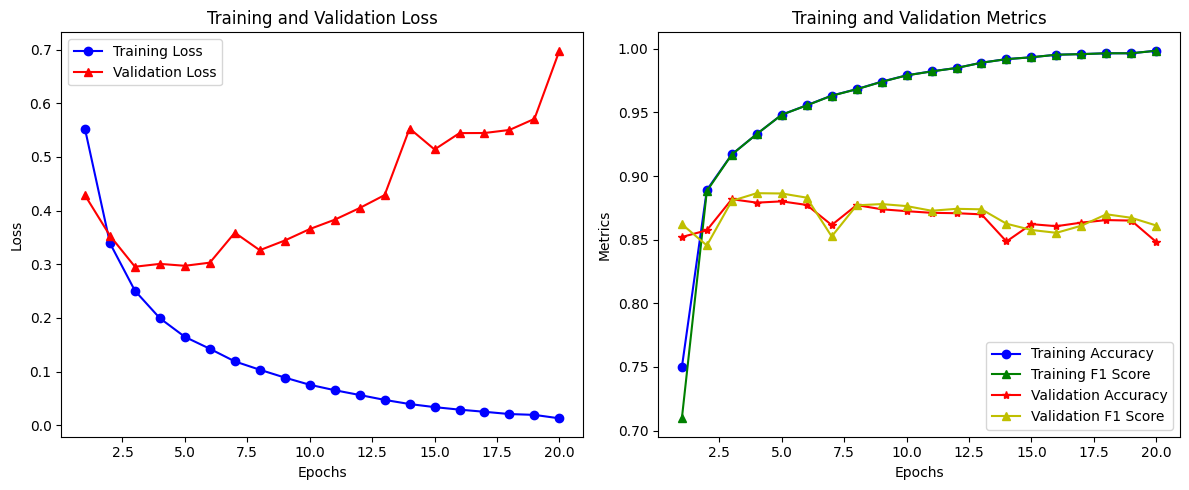

In [34]:
import matplotlib.pyplot as plt

# Plotting the training and validation loss
epochs = range(1, len(history.history['loss']) + 1)

plt.figure(figsize=(12, 5))

# Training and validation loss
plt.subplot(1, 2, 1)
plt.plot(epochs, history.history['loss'], 'bo-', label='Training Loss')
plt.plot(epochs, history.history['val_loss'], 'r^-', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Accuracy and F1 score
plt.subplot(1, 2, 2)
plt.plot(epochs, history.history['accuracy'], 'bo-', label='Training Accuracy')
plt.plot(epochs, history.history['f1_score'], 'g^-', label='Training F1 Score')
plt.plot(epochs, history.history['val_accuracy'], 'r*-', label='Validation Accuracy')
plt.plot(epochs, history.history['val_f1_score'], 'y^-', label='Validation F1 Score')
plt.title('Training and Validation Metrics')
plt.xlabel('Epochs')
plt.ylabel('Metrics')
plt.legend()

plt.tight_layout()
plt.show()

In [33]:
# 모델 예측
y_pred = model.predict(test_data)  # train_data 대신 테스트 데이터로 변경 가능
y_true = test_labels  # 실제 라벨

# 다양한 Threshold에 따른 Precision, Recall, F1 Score 계산
thresholds = np.linspace(0.1, 0.9, 9)
best_threshold = 0
best_f1 = 0

for threshold in thresholds:
    y_pred_binary = (y_pred > threshold).astype(int)  # Threshold를 기준으로 이진화
    precision = precision_score(y_true, y_pred_binary)
    recall = recall_score(y_true, y_pred_binary)
    f1 = f1_score(y_true, y_pred_binary)
    print(f"Threshold: {threshold:.2f}, Precision: {precision:.3f}, Recall: {recall:.3f}, F1 Score: {f1:.3f}")

    # F1 Score가 최대가 되는 Threshold 찾기
    if f1 > best_f1:
        best_f1 = f1
        best_threshold = threshold

print(f"\nBest Threshold: {best_threshold:.2f}, Best F1 Score: {best_f1:.3f}")

782/782 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Threshold: 0.10, Precision: 0.737, Recall: 0.960, F1 Score: 0.833
Threshold: 0.20, Precision: 0.756, Recall: 0.950, F1 Score: 0.842
Threshold: 0.30, Precision: 0.768, Recall: 0.943, F1 Score: 0.847
Threshold: 0.40, Precision: 0.780, Recall: 0.937, F1 Score: 0.851
Threshold: 0.50, Precision: 0.790, Recall: 0.929, F1 Score: 0.854
Threshold: 0.60, Precision: 0.799, Recall: 0.921, F1 Score: 0.856
Threshold: 0.70, Precision: 0.812, Recall: 0.911, F1 Score: 0.859
Threshold: 0.80, Precision: 0.825, Recall: 0.897, F1 Score: 0.859
Threshold: 0.90, Precision: 0.842, Recall: 0.874, F1 Score: 0.858

Best Threshold: 0.80, Best F1 Score: 0.859


### 회고

F1 Score 가 이상하게 나오는 것을 캐치 하고 수정 하기 위해 엄청 많은 시간이 걸렸다.  
사실 이 정도 시간이 걸리는게 아니였는데 아직 TensorFlow 에 익숙하지 않고 특히 shape 을 꼭 확인 해야 되는걸 망각하고 있었다.  
아무튼 해결 완료!

Precision과 Recall의 트레이드오프:

Threshold가 낮을수록 Recall(재현율)이 높아지고, Precision(정밀도)은 낮아짐
반대로 Threshold가 높아질수록 Precision은 증가하지만 Recall은 감소

